# Coursera Capstone Project - The Battle of Neighbourhoods

This notebook will be mainly used for IBM Applied Data Science Capstone course on Coursera.

## Introduction

New Delhi is the capital city of India. It is a part of the city of Delhi’s 11 districts. The city itself has large population. However, the much larger metro area has a population that exceeds 30 million.

With Delhi's diverse culture , comes diverse food items. There are many restaurants in New Delhi City, each belonging to different categories like Chinese , Italian , French etc. So as part of this project , we will list and visualise all major parts of New Delhi City .

### Questions that can be asked as part of our problem statement

* What is the best location in New Delhi City for Chinese Cuisine?
* Which areas have large number of Chinese Restaurants?
* Which all areas have less number of restaurants?
* Which is the best place to stay if someone prefers Chinese Cuisine?

### Intended Audience

1. People or Customers who want to know where they can enjoy the food they want.
2. Business persons who want to start their restaurant and analyzing the right locality for the restaurant according to food they serve.
3. Government or Any organization who wants to analyze the New Delhi Restaurants data and localities where particular type of food is being liked by the people.

### Data

* New Delhi Restaurants data that contains list Locality, Restaurant name, Rating along with their latitude and longitude
    * __Data source__ : [Zomato kaggle dataset](https://www.kaggle.com/shrutimehta/zomato-restaurants-data)
    * __Description of Data__: This dataset contains the locality of different restaurants, along with their ratings given by customers. The Latitude and Longitude are also provided.
    * __Example__: if i want to know best locality of chinese restaurant in New Delhi city then from dataset, we will group the restaurants in the same locality
* Nearby places in each locality of new delhi city
    * __Data source__ : [Foursquare API](https://developer.foursquare.com/)
    * __Description__: The foursquare api will be used to get all the nearby venues in each neighborhood.
    * __Example__: Using this we will find the venues in all or selected neighborhood. And then by filtering out nearby locality and the aggregating the rating of each restaurant, we get the best places.

## Approach

* Collect the new delhi city data from Zomato kaggle dataset.
* Using FourSquare API we will find all venues for each neighborhood.
* Filter out all venues that are nearby by locality.
* Using aggregative rating for each resturant to find the best places.
* Visualize the Ranking of neighborhoods using folium library(python).

In [1]:
import pandas as pd
import numpy as np

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
! pip install geocoder
import geocoder

Solving environment: done

# All requested packages already installed.



## Read the zomato resturant data from csv file

In [2]:
df = pd.read_csv('zomato.csv', encoding='latin-1')
df.head()

Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   
2  Edsa Shangri-La, Ortigas, Mandaluyong City   
3      SM Megamall, Ortigas, Mandaluyong City   
4      SM Megamall, Ortigas, Mandaluyong City   

                                    Locality Verbose   Longitude   Latitude  \
0  Century City Mall, Poblacion, Makati City, Mak...  121.027535  14.565443   
1  Little Tokyo, Legaspi Village, Makati City, Ma...  121.014101  14.553708   
2  Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...  121.056831  14.581404   
3  SM Megamall, Ortigas, Mandaluyong City, Mandal...  121.056475  14.585318   
4  SM Megamall, Ortigas, Mandaluyong City, Mandal...  121.057508  14.584450   

                           Cuisines  ...          Currency Has Table booking  \
0        French, Japanese, Desserts  ...  Botswana Pula(P)               Yes   
1                          Japanese  ...  Botswana Pula(P)               Yes   
2  Seafood, Asian, Filipino, Indian  ...  Botswana Pula(P)               Yes   
3                   Japanese, Sushi  ...  Botswana Pula(P)                No   
4                  Japanese, Korean  ...  Botswana Pula(P)               Yes   

  Has Online delivery Is delivering now Switch to order menu Price range  \
0                  No                No                   No           3   
1                  No                No                   No           3   
2                  No                No                   No           4   
3                  No                No                   No           4   
4                  No                No                   No           4   

   Aggregate rating  Rating color Rating text Votes  
0               4.8    Dark Green   Excellent   314  
1               4.5    Dark Green   Excellent   591  
2               4.4         Green   Very Good   270  
3               4.9    Dark Green   Excellent   365  
4               4.8    Dark Green   Excellent   229  

[5 rows x 21 columns]

In [3]:
df_india = df[df['Country Code'] == 1]
df_NDLS = df_india[df_india['City'] == 'New Delhi']
df_NDLS.reset_index(drop=True, inplace=True)
df_NDLS.head()

Restaurant ID  Restaurant Name  Country Code       City  \
0       18287358       Food Cloud             1  New Delhi   
1       18216944        Burger.in             1  New Delhi   
2         313333  Days of the Raj             1  New Delhi   
3       18384127   Dilli Ka Dhaba             1  New Delhi   
4            582        Govardhan             1  New Delhi   

                                             Address    Locality  \
0                              Aaya Nagar, New Delhi  Aaya Nagar   
1        84, Near Honda Showroom, Adchini, New Delhi     Adchini   
2  81/3, 1st Floor, Qutub Residency, Adchini, New...     Adchini   
3  66 A, Ground Floor, Sri Aurobindo Marg, Adchin...     Adchini   
4  84, Adjacent Hero Motor Bike Showroom, Main Me...     Adchini   

        Locality Verbose  Longitude   Latitude  \
0  Aaya Nagar, New Delhi   0.000000   0.000000   
1     Adchini, New Delhi  77.196923  28.535382   
2     Adchini, New Delhi  77.197475  28.535493   
3     Adchini, New Delhi  77.198033  28.537547   
4     Adchini, New Delhi  77.196924  28.535523   

                              Cuisines  ...            Currency  \
0                       Cuisine Varies  ...  Indian Rupees(Rs.)   
1                            Fast Food  ...  Indian Rupees(Rs.)   
2   North Indian, Seafood, Continental  ...  Indian Rupees(Rs.)   
3           South Indian, North Indian  ...  Indian Rupees(Rs.)   
4  South Indian, North Indian, Chinese  ...  Indian Rupees(Rs.)   

  Has Table booking Has Online delivery Is delivering now  \
0                No                  No                No   
1                No                 Yes                No   
2               Yes                 Yes                No   
3                No                  No                No   
4                No                 Yes                No   

  Switch to order menu Price range  Aggregate rating  Rating color  \
0                   No           2               0.0         White   
1                   No           1               3.2        Orange   
2                   No           3               3.4        Orange   
3                   No           2               2.6        Orange   
4                   No           2               3.4        Orange   

  Rating text Votes  
0   Not rated     2  
1     Average    46  
2     Average    45  
3     Average    11  
4     Average   238  

[5 rows x 21 columns]

## Data Cleaning

remove the unwanted columns and rows from dataset

In [4]:
df_Res= df_NDLS[df_NDLS.Longitude !=0.000000][['Restaurant Name','Locality','Longitude','Latitude','Cuisines','Aggregate rating','Rating text','Votes']]

In [5]:
df_Res = df_Res[df_Res['Aggregate rating'] !=0.0]

In [6]:
df_Res.head()

Restaurant Name Locality  Longitude   Latitude  \
1        Burger.in  Adchini  77.196923  28.535382   
2  Days of the Raj  Adchini  77.197475  28.535493   
3   Dilli Ka Dhaba  Adchini  77.198033  28.537547   
4        Govardhan  Adchini  77.196924  28.535523   
5   Mezbaan Grills  Adchini  77.198122  28.538134   

                              Cuisines  Aggregate rating Rating text  Votes  
1                            Fast Food               3.2     Average     46  
2   North Indian, Seafood, Continental               3.4     Average     45  
3           South Indian, North Indian               2.6     Average     11  
4  South Indian, North Indian, Chinese               3.4     Average    238  
5                              Mughlai               3.1     Average      8

## Created map to show the restaurant cluters

In [7]:
New_Delhi_Rest = folium.Map(location=[28.52, 77.25], zoom_start=12)

X = df_Res['Latitude']
Y = df_Res['Longitude']
Z = np.stack((X, Y), axis=1)

kmeans = KMeans(n_clusters=5, random_state=0).fit(Z)

clusters = kmeans.labels_
colors = ['red', 'green', 'blue', 'yellow','orange']
df_Res ['Cluster'] = clusters

for latitude, longitude, Locality, cluster in zip(df_Res['Latitude'], df_Res['Longitude'], df_Res['Locality'], df_Res['Cluster']):
    label = folium.Popup(Locality, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(New_Delhi_Rest)  

New_Delhi_Rest

In [8]:
df_Res.head()

Restaurant Name Locality  Longitude   Latitude  \
1        Burger.in  Adchini  77.196923  28.535382   
2  Days of the Raj  Adchini  77.197475  28.535493   
3   Dilli Ka Dhaba  Adchini  77.198033  28.537547   
4        Govardhan  Adchini  77.196924  28.535523   
5   Mezbaan Grills  Adchini  77.198122  28.538134   

                              Cuisines  Aggregate rating Rating text  Votes  \
1                            Fast Food               3.2     Average     46   
2   North Indian, Seafood, Continental               3.4     Average     45   
3           South Indian, North Indian               2.6     Average     11   
4  South Indian, North Indian, Chinese               3.4     Average    238   
5                              Mughlai               3.1     Average      8   

   Cluster  
1        0  
2        0  
3        0  
4        0  
5        0

## What places are have best restaurant in New Delhi?

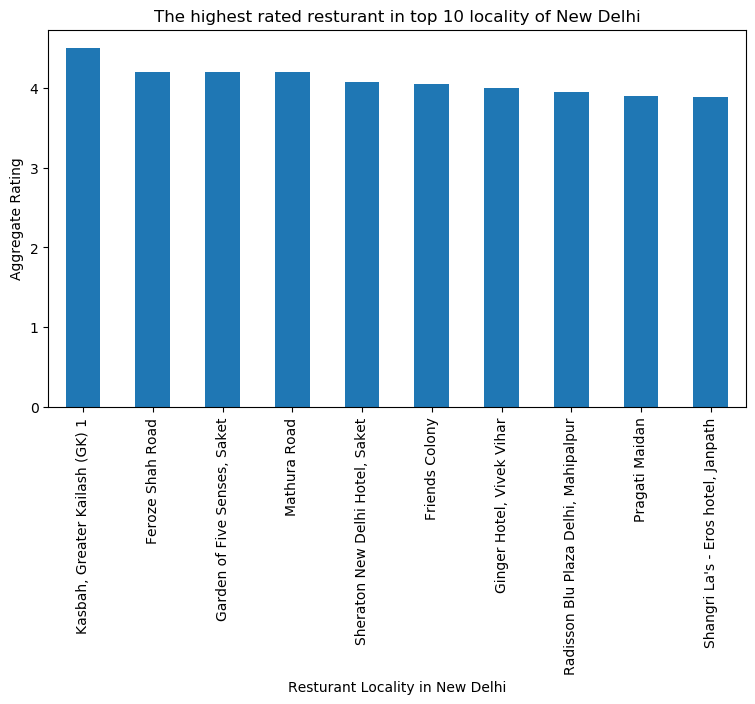

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The highest rated resturant in top 10 locality of New Delhi')
#On x-axis

#giving a bar plot
df_Res.groupby('Locality')['Aggregate rating'].mean().nlargest(10).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Aggregate Rating')
#displays the plot
plt.show()

The best restarants are available in Kesbah, Greater Kailash area.

## what places are have worst restaurants in New Delhi?

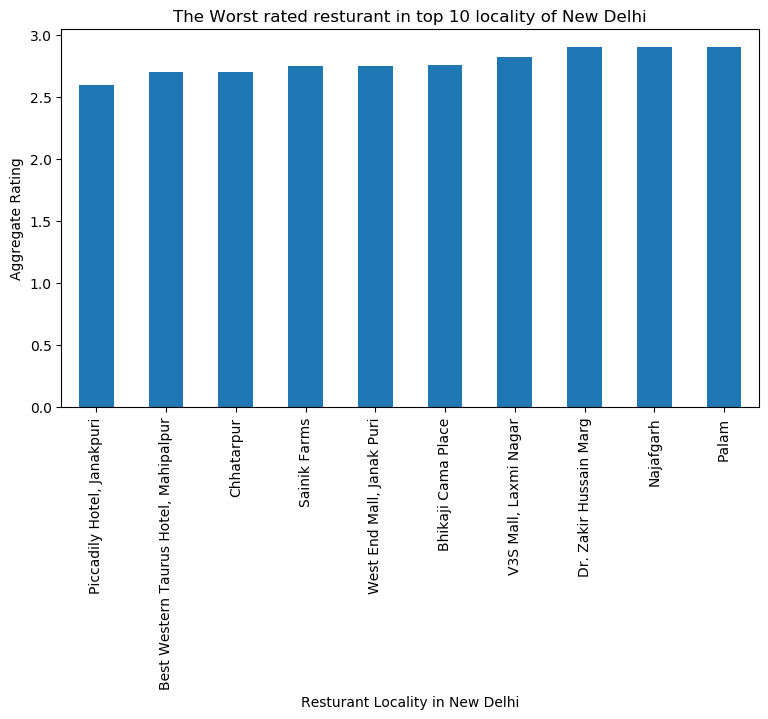

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The Worst rated resturant in top 10 locality of New Delhi')
#On x-axis

#giving a bar plot
df_Res.groupby('Locality')['Aggregate rating'].mean().nsmallest(10).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Aggregate Rating')

#displays the plot
plt.show()

The worst restarants are available in Piccadily Hotel, Janakpuri.

## Which place are suitable for edible person in New Delhi city?

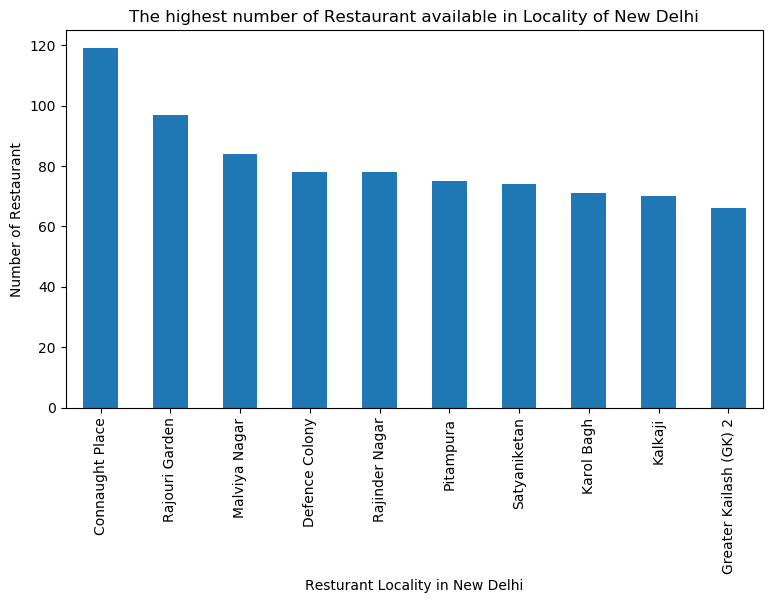

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The highest number of Restaurant available in Locality of New Delhi')
#On x-axis

#giving a bar plot
df_Res.groupby('Locality')['Restaurant Name'].count().nlargest(10).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Number of Restaurant')

#displays the plot
plt.show()

Connaught Place is the best places for edible person to stay there.

## Which place are not suitable for edible person in New Delhi city?

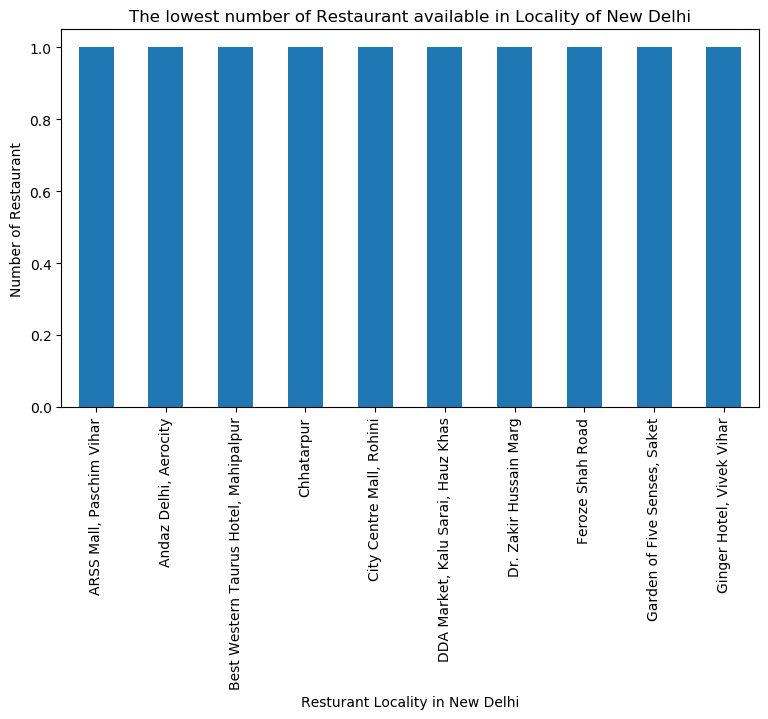

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The lowest number of Restaurant available in Locality of New Delhi')
#On x-axis

#giving a bar plot
df_Res.groupby('Locality')['Restaurant Name'].count().nsmallest(10).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Number of Restaurant')

#displays the plot
plt.show()

## What are the best places for chinese restaurant in New Delhi city

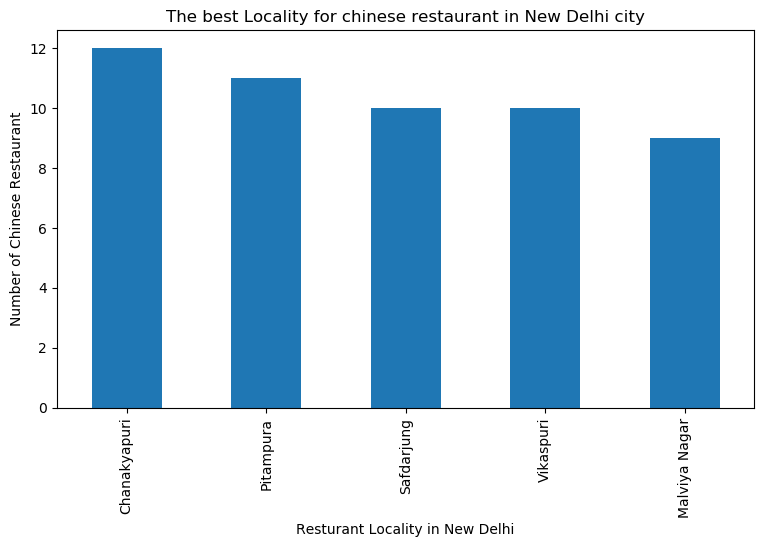

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The best Locality for chinese restaurant in New Delhi city')
#On x-axis

#giving a bar plot
df_Res[df_Res['Cuisines'].str.startswith('Chinese')].groupby('Locality')['Restaurant Name'].count().nlargest(5).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Number of Chinese Restaurant')

#displays the plot
plt.show()

Chanakyapuri is the best place for Chinese restaurant.

## which places are the best chinese resturants in New Delhi?

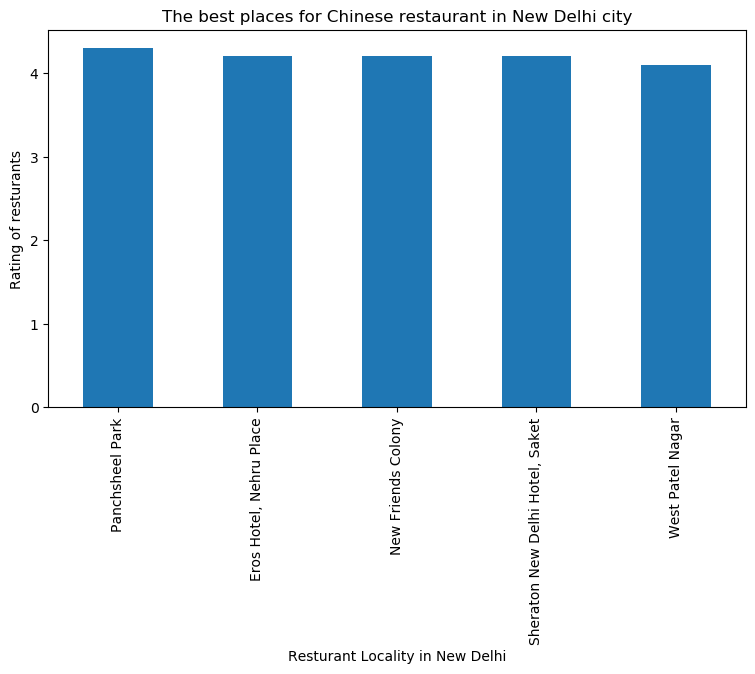

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The best places for Chinese restaurant in New Delhi city')
#On x-axis

#giving a bar plot
df_Res[df_Res['Cuisines'].str.startswith('Chinese')].groupby('Locality')['Aggregate rating'].mean().nlargest(5).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Rating of resturants')

#displays the plot
plt.show()

Panchsheel park is best Chinese resturants.

## Data transformation

Based on Locality grouping the data

In [16]:
df_Res_Loc =  df_Res.groupby('Locality').count()['Restaurant Name'].to_frame()
df_Res_rating= df_Res.groupby('Locality')['Aggregate rating'].mean().to_frame()
d_Cuisines = df_Res.groupby(['Locality'])['Cuisines'].agg(', '.join).reset_index()
d_R = df_Res.groupby(['Locality'])['Rating text'].unique().agg(', '.join).reset_index()
d_V = df_Res.groupby(['Locality'])['Votes'].sum().to_frame()
d_Lat = df_Res.groupby('Locality').mean()['Latitude'].to_frame()
d_Lng = df_Res.groupby('Locality').mean()['Longitude'].to_frame()
df_final = pd.merge(d_Lat,d_Lng,on='Locality').merge(df_Res_Loc, on='Locality').merge(d_Cuisines, on='Locality').merge(df_Res_rating,on ='Locality').merge(d_R, on ='Locality').merge(d_V, on ='Locality')

In [17]:
df_final = df_final[df_final['Aggregate rating'] != 0.000000]
df_final.columns =['Locality','Lat','Lng', 'No_of_Restaurant','Cusines', 'Agg_Rating','Comments' ,'No_of_Votes']
df_final.head()

Locality        Lat        Lng  No_of_Restaurant  \
0       ARSS Mall, Paschim Vihar  28.668945  77.101544                 1   
1                        Adchini  28.537063  77.197808                13   
2  Aditya Mega Mall, Karkardooma  28.656131  77.301266                 4   
3                       Aerocity  28.553077  77.104270                 2   
4  Aggarwal City Mall, Pitampura  28.690020  77.134650                 3   

                                             Cusines  Agg_Rating  \
0  North Indian, South Indian, Chinese, Mithai, F...    3.100000   
1  Fast Food, North Indian, Seafood, Continental,...    3.292308   
2  Finger Food, North Indian, Mughlai, Pizza, Fas...    3.275000   
3  Fast Food, Italian, Pizza, North Indian, Conti...    3.200000   
4  North Indian, Chinese, Street Food, Mithai, No...    3.033333   

                         Comments  No_of_Votes  
0                         Average          117  
1  Average, Good, Poor, Very Good         1560  
2                   Average, Good          434  
3                         Average           59  
4                         Average          126

In [18]:
df_final.shape

(240, 8)

## Define Foursquare Credentials and Version

In [24]:
## Define Foursquare Credentials and Version
CLIENT_ID = 'Y3VVY3VXK5V0YRIKVB1WY5A3SCDVTXJDI2Q0GHD3YQDGSEND' # Foursquare ID
CLIENT_SECRET = '41CYVXEOWQSBIB0KDUD3RYVGJLC4JJXH44HXWAFOOGDC1JVH' # Foursquare Secret
VERSION = '20200620' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Y3VVY3VXK5V0YRIKVB1WY5A3SCDVTXJDI2Q0GHD3YQDGSEND
CLIENT_SECRET:41CYVXEOWQSBIB0KDUD3RYVGJLC4JJXH44HXWAFOOGDC1JVH


## Create a function to repeat the same process to all the Locality in New Delhi

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT = 30):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Locality', 'Locality Latitude', 'Locality Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

## Find the venues in all New Delhi Locality

In [30]:
new_Delhi_venues = getNearbyVenues(names=df_final['Locality'],
                                   latitudes=df_final['Lat'],
                                   longitudes=df_final['Lng']
                                  )

ARSS Mall, Paschim Vihar
Adchini
Aditya Mega Mall, Karkardooma
Aerocity
Aggarwal City Mall, Pitampura
Aggarwal City Plaza, Rohini
Alaknanda
Ambience Mall, Vasant Kunj
Anand Lok
Anand Vihar
Andaz Delhi, Aerocity
Ansal Plaza Mall, Khel Gaon Marg
Asaf Ali Road
Ashok Vihar Phase 1
Ashok Vihar Phase 2
Ashok Vihar Phase 3
Barakhamba Road
Basant Lok Market, Vasant Vihar
Bellagio, Ashok Vihar Phase 2
Best Western Taurus Hotel, Mahipalpur
Bhikaji Cama Place
Chanakyapuri
Chander Nagar
Chandni Chowk
Chawri Bazar
Chhatarpur
Chittaranjan Park
City Centre Mall, Rohini
City Square Mall, Rajouri Garden
Civil Lines
Community Centre, New Friends Colony
Connaught Place
Crescent Square Mall, Rohini
Cross River Mall, Karkardooma
Crowne Plaza Hotel, Rohini
Crowne Plaza, Mayur Vihar Phase 1
D Mall, Netaji Subhash Place
DDA Market, Kalu Sarai, Hauz Khas
DLF City Centre Mall, Shalimar Bagh
DLF Emporio Mall, Vasant Kunj
DLF Place Mall, Saket
DLF Promenade Mall, Vasant Kunj
DLF South Square, Sarojini Nagar
Darya

In [31]:
new_Delhi_venues.head()

Locality  Locality Latitude  Locality Longitude  \
0  ARSS Mall, Paschim Vihar          28.668945           77.101544   
1  ARSS Mall, Paschim Vihar          28.668945           77.101544   
2  ARSS Mall, Paschim Vihar          28.668945           77.101544   
3  ARSS Mall, Paschim Vihar          28.668945           77.101544   
4  ARSS Mall, Paschim Vihar          28.668945           77.101544   

                         Venue  Venue Latitude  Venue Longitude  \
0                       Subway       28.669999        77.102546   
1  Baljeet's Amritsari Koolcha       28.665768        77.100481   
2                    Pizza Hut       28.670321        77.103853   
3              Café Coffee Day       28.670009        77.102480   
4                  Little Chef       28.670000        77.101459   

       Venue Category  
0      Sandwich Place  
1   Indian Restaurant  
2         Pizza Place  
3         Coffee Shop  
4  Chinese Restaurant

In [32]:
new_Delhi_venues.groupby('Locality').count()

Locality Latitude  Locality Longitude  Venue  \
Locality                                                                       
ARSS Mall, Paschim Vihar                        9                   9      9   
Adchini                                         7                   7      7   
Aditya Mega Mall, Karkardooma                  10                  10     10   
Aerocity                                        7                   7      7   
Aggarwal City Mall, Pitampura                   5                   5      5   
...                                           ...                 ...    ...   
West Gate Mall, Rajouri Garden                 14                  14     14   
West Patel Nagar                                5                   5      5   
Worldmark 1, Aerocity                          29                  29     29   
Yusuf Sarai                                    13                  13     13   
ibis New Delhi, Aerocity                       29                  29     29   

                                Venue Latitude  Venue Longitude  \
Locality                                                          
ARSS Mall, Paschim Vihar                     9                9   
Adchini                                      7                7   
Aditya Mega Mall, Karkardooma               10               10   
Aerocity                                     7                7   
Aggarwal City Mall, Pitampura                5                5   
...                                        ...              ...   
West Gate Mall, Rajouri Garden              14               14   
West Patel Nagar                             5                5   
Worldmark 1, Aerocity                       29               29   
Yusuf Sarai                                 13               13   
ibis New Delhi, Aerocity                    29               29   

                                Venue Category  
Locality                                        
ARSS Mall, Paschim Vihar                     9  
Adchini                                      7  
Aditya Mega Mall, Karkardooma               10  
Aerocity                                     7  
Aggarwal City Mall, Pitampura                5  
...                                        ...  
West Gate Mall, Rajouri Garden              14  
West Patel Nagar                             5  
Worldmark 1, Aerocity                       29  
Yusuf Sarai                                 13  
ibis New Delhi, Aerocity                    29  

[239 rows x 6 columns]

In [33]:
print('There are {} uniques categories.'.format(len(new_Delhi_venues['Venue Category'].unique())))

There are 207 uniques categories.


In [34]:
## Analyze Each Locality

# one hot encoding
new_Delhi_onehot = pd.get_dummies(new_Delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add Locality column back to dataframe
new_Delhi_onehot['Locality'] = new_Delhi_venues['Locality'] 

# move Locality column to the first column
column_list = new_Delhi_onehot.columns.tolist()
column_number = int(column_list.index('Locality'))
column_list = [column_list[column_number]] + column_list[:column_number] + column_list[column_number+1:]
new_Delhi_onehot = new_Delhi_onehot[column_list]

new_Delhi_onehot.head()

Locality  ATM  Accessories Store  Afghan Restaurant  \
0  ARSS Mall, Paschim Vihar    0                  0                  0   
1  ARSS Mall, Paschim Vihar    0                  0                  0   
2  ARSS Mall, Paschim Vihar    0                  0                  0   
3  ARSS Mall, Paschim Vihar    0                  0                  0   
4  ARSS Mall, Paschim Vihar    0                  0                  0   

   African Restaurant  Airport  Airport Food Court  Airport Lounge  \
0                   0        0                   0               0   
1                   0        0                   0               0   
2                   0        0                   0               0   
3                   0        0                   0               0   
4                   0        0                   0               0   

   Airport Service  Airport Terminal  ...  Trail  Train Station  \
0                0                 0  ...      0              0   
1                0                 0  ...      0              0   
2                0                 0  ...      0              0   
3                0                 0  ...      0              0   
4                0                 0  ...      0              0   

   Turkish Restaurant  Udupi Restaurant  Vegetarian / Vegan Restaurant  \
0                   0                 0                              0   
1                   0                 0                              0   
2                   0                 0                              0   
3                   0                 0                              0   
4                   0                 0                              0   

   Vietnamese Restaurant  Whisky Bar  Wine Bar  Wings Joint  Women's Store  
0                      0           0         0            0              0  
1                      0           0         0            0              0  
2                      0           0         0            0              0  
3                      0           0         0            0              0  
4                      0           0         0            0              0  

[5 rows x 208 columns]

In [35]:
New_Delhi_grouped = new_Delhi_onehot.groupby('Locality').mean().reset_index()
New_Delhi_grouped

Locality       ATM  Accessories Store  \
0          ARSS Mall, Paschim Vihar  0.111111           0.000000   
1                           Adchini  0.000000           0.000000   
2     Aditya Mega Mall, Karkardooma  0.000000           0.000000   
3                          Aerocity  0.000000           0.000000   
4     Aggarwal City Mall, Pitampura  0.000000           0.000000   
..                              ...       ...                ...   
234  West Gate Mall, Rajouri Garden  0.000000           0.000000   
235                West Patel Nagar  0.000000           0.000000   
236           Worldmark 1, Aerocity  0.000000           0.034483   
237                     Yusuf Sarai  0.000000           0.000000   
238        ibis New Delhi, Aerocity  0.000000           0.000000   

     Afghan Restaurant  African Restaurant  Airport  Airport Food Court  \
0                  0.0                 0.0      0.0                 0.0   
1                  0.0                 0.0      0.0                 0.0   
2                  0.0                 0.0      0.0                 0.0   
3                  0.0                 0.0      0.0                 0.0   
4                  0.0                 0.0      0.0                 0.0   
..                 ...                 ...      ...                 ...   
234                0.0                 0.0      0.0                 0.0   
235                0.0                 0.0      0.0                 0.0   
236                0.0                 0.0      0.0                 0.0   
237                0.0                 0.0      0.0                 0.0   
238                0.0                 0.0      0.0                 0.0   

     Airport Lounge  Airport Service  Airport Terminal  ...  Trail  \
0          0.000000              0.0          0.000000  ...    0.0   
1          0.000000              0.0          0.000000  ...    0.0   
2          0.000000              0.0          0.000000  ...    0.0   
3          0.142857              0.0          0.142857  ...    0.0   
4          0.000000              0.0          0.000000  ...    0.0   
..              ...              ...               ...  ...    ...   
234        0.000000              0.0          0.000000  ...    0.0   
235        0.000000              0.0          0.000000  ...    0.0   
236        0.000000              0.0          0.000000  ...    0.0   
237        0.000000              0.0          0.000000  ...    0.0   
238        0.000000              0.0          0.000000  ...    0.0   

     Train Station  Turkish Restaurant  Udupi Restaurant  \
0         0.000000                 0.0               0.0   
1         0.000000                 0.0               0.0   
2         0.000000                 0.0               0.0   
3         0.000000                 0.0               0.0   
4         0.000000                 0.0               0.0   
..             ...                 ...               ...   
234       0.000000                 0.0               0.0   
235       0.000000                 0.0               0.0   
236       0.034483                 0.0               0.0   
237       0.000000                 0.0               0.0   
238       0.034483                 0.0               0.0   

     Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Whisky Bar  \
0                              0.0                    0.0         0.0   
1                              0.0                    0.0         0.0   
2                              0.0                    0.0         0.0   
3                              0.0                    0.0         0.0   
4                              0.0                    0.0         0.0   
..                             ...                    ...         ...   
234                            0.0                    0.0         0.0   
235                            0.0                    0.0         0.0   
236                            0.0                    0.0         0.0   
237              

In [36]:
New_Delhi_grouped.shape

(239, 208)

In [37]:
## print each Locality along with the top 5 most common venues

num_top_venues = 5

for hood in New_Delhi_grouped['Locality']:
    print("----"+hood+"----")
    temp = New_Delhi_grouped[New_Delhi_grouped['Locality'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ARSS Mall, Paschim Vihar----
                venue  freq
0   Indian Restaurant  0.22
1                 ATM  0.11
2              Market  0.11
3         Coffee Shop  0.11
4  Chinese Restaurant  0.11


----Adchini----
               venue  freq
0  Indian Restaurant  0.29
1                Pub  0.29
2               Café  0.29
3        Coffee Shop  0.14
4                ATM  0.00


----Aditya Mega Mall, Karkardooma----
               venue  freq
0        Pizza Place   0.2
1          Multiplex   0.2
2  Indian Restaurant   0.2
3      Shopping Mall   0.2
4              Hotel   0.1


----Aerocity----
                  venue  freq
0                 Hotel  0.29
1        Airport Lounge  0.14
2  Fast Food Restaurant  0.14
3           Coffee Shop  0.14
4   Rental Car Location  0.14


----Aggarwal City Mall, Pitampura----
                   venue  freq
0      Indian Restaurant   0.4
1            Pizza Place   0.2
2   Fast Food Restaurant   0.2
3       Department Store   0.2
4  Performing Arts Venu

                  venue  freq
0           Pizza Place  0.18
1            Donut Shop  0.09
2  Fast Food Restaurant  0.09
3                  Café  0.09
4                   Bar  0.09


----Hotel The Royal Plaza, Janpath----
                venue  freq
0               Hotel  0.23
1   Indian Restaurant  0.13
2                 Spa  0.10
3          Restaurant  0.07
4  Italian Restaurant  0.07


----Hyatt Regency, Bhikaji Cama Place----
                  venue  freq
0                Lounge  0.15
1                 Hotel  0.15
2  Fast Food Restaurant  0.08
3    Chinese Restaurant  0.08
4      Asian Restaurant  0.08


----INA----
                         venue  freq
0                       Market  0.25
1            Indian Restaurant  0.25
2                Train Station  0.25
3  Northeast Indian Restaurant  0.25
4                          ATM  0.00


----IP Extension----
               venue  freq
0  Indian Restaurant   0.2
1          Gift Shop   0.1
2             Market   0.1
3               Food

                 venue  freq
0          Pizza Place   0.2
1        Event Service   0.2
2          Event Space   0.2
3  American Restaurant   0.2
4     Business Service   0.2


----Pandara Road Market----
               venue  freq
0  Indian Restaurant  0.33
1         Smoke Shop  0.07
2  Food & Drink Shop  0.07
3         Restaurant  0.07
4        Snack Place  0.07


----Pandav Nagar----
               venue  freq
0       Dessert Shop  0.22
1      Moving Target  0.11
2  Convenience Store  0.11
3               Park  0.11
4        Bus Station  0.11


----Paschim Vihar----
                            venue  freq
0                     Pizza Place  0.12
1                     Coffee Shop  0.12
2                  Sandwich Place  0.12
3              Chinese Restaurant  0.12
4  Multicuisine Indian Restaurant  0.12


----Patparganj----
               venue  freq
0  Indian Restaurant  0.25
1          Gift Shop  0.12
2             Market  0.12
3               Café  0.12
4      Shopping Mall  0.12




                venue  freq
0               Hotel  0.75
1   Indian Restaurant  0.25
2                 ATM  0.00
3      Nightlife Spot  0.00
4  Mughlai Restaurant  0.00


----The Village Restaurant Complex, Khel Gaon Marg----
                venue  freq
0                 Bar  0.18
1         Coffee Shop  0.09
2   Indian Restaurant  0.09
3  Chinese Restaurant  0.09
4             Theater  0.09


----Tilak Nagar----
                            venue  freq
0            Fast Food Restaurant  0.67
1                   Metro Station  0.33
2                             ATM  0.00
3                  Nightlife Spot  0.00
4  Multicuisine Indian Restaurant  0.00


----Tughlakabad Institutional Area----
        venue  freq
0  Steakhouse  0.17
1         Bar  0.17
2  Restaurant  0.17
3       Hotel  0.17
4      Market  0.17


----Uday Park----
           venue  freq
0         Market   0.2
1           Park   0.2
2    Music Venue   0.2
3           Café   0.2
4  Metro Station   0.2


----Unity One Mall, Jana

In [38]:
## put that into a pandas dataframe
## First, write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
## create the new dataframe and display the top 10 venues for each Locality.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Locality']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Locality_venues_sorted = pd.DataFrame(columns=columns)
Locality_venues_sorted['Locality'] = New_Delhi_grouped['Locality']

for ind in np.arange(New_Delhi_grouped.shape[0]):
    Locality_venues_sorted.iloc[ind, 1:] = return_most_common_venues(New_Delhi_grouped.iloc[ind, :], num_top_venues)

Locality_venues_sorted

Locality 1st Most Common Venue  \
0          ARSS Mall, Paschim Vihar     Indian Restaurant   
1                           Adchini                  Café   
2     Aditya Mega Mall, Karkardooma           Pizza Place   
3                          Aerocity                 Hotel   
4     Aggarwal City Mall, Pitampura     Indian Restaurant   
..                              ...                   ...   
234  West Gate Mall, Rajouri Garden  Fast Food Restaurant   
235                West Patel Nagar           Pizza Place   
236           Worldmark 1, Aerocity                 Hotel   
237                     Yusuf Sarai     Indian Restaurant   
238        ibis New Delhi, Aerocity                 Hotel   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                     ATM        Sandwich Place                Market   
1       Indian Restaurant                   Pub           Coffee Shop   
2           Shopping Mall             Multiplex     Indian Restaurant   
3    Fast Food Restaurant        Airport Lounge           Coffee Shop   
4             Pizza Place      Department Store  Fast Food Restaurant   
..                    ...                   ...                   ...   
234                  Café           Snack Place            Hookah Bar   
235                  Park        Farmers Market             Juice Bar   
236             Hotel Bar       Bed & Breakfast            Restaurant   
237           Coffee Shop        Ice Cream Shop                  Park   
238             Hotel Bar           Coffee Shop            Restaurant   

              5th Most Common Venue 6th Most Common Venue  \
0    Multicuisine Indian Restaurant           Coffee Shop   
1                     Women's Store    Frozen Yogurt Shop   
2                             Hotel                  Café   
3                  Airport Terminal   Rental Car Location   
4                    Farmers Market    Frozen Yogurt Shop   
..                              ...                   ...   
234                       Multiplex            Restaurant   
235                    Dance Studio                 Diner   
236                     Coffee Shop         Shopping Mall   
237             Japanese Restaurant                   Bar   
238                          Bakery                   Spa   

    7th Most Common Venue   8th Most Common Venue 9th Most Common Venue  \
0      Chinese Restaurant             Pizza Place       Airport Service   
1     Fried Chicken Joint       French Restaurant            Food Truck   
2      African Restaurant       Fish & Chips Shop    Frozen Yogurt Shop   
3           Women's Store      Frozen Yogurt Shop   Fried Chicken Joint   
4     Fried Chicken Joint       French Restaurant            Food Truck   
..                    ...                     ...                   ...   
234   American Restaurant           Shopping Mall     Indian Restaurant   
235            Donut Shop  Furniture / Home Store    Frozen Yogurt Shop   
236            Food Court                  Bakery                   Spa   
237                 Hotel            Dessert Shop      Asian Restaurant   
238     Indian Restaurant      Punjabi Restaurant         Shopping Mall   

    10th Most Common Venue  
0             Dessert Shop  
1               Food Court  
2      Fried Chicken Joint  
3        French Restaurant  
4               Food Court  
..                     ...  
234         Ice Cream Shop  
235    Fried Chicken Joint  
236                 Lounge  
237      Korean Restaurant  
238     Italian Restaurant  

[239 rows x 11 columns]

In [40]:
## Cluster Locality
## Run k-means to cluster the Locality into 5 clusters.

# set number of clusters
kclusters = 5

New_Delhi_clustering = New_Delhi_grouped.drop('Locality', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(New_Delhi_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
kmeans.labels_.shape

(239,)

In [42]:
# add clustering labels
New_Delhi_merged = df_final.head(239)
New_Delhi_merged['Cluster Labels'] = kmeans.labels_

# merge New_Delhi_grouped with df_Chinese to add latitude/longitude for each Locality
New_Delhi_merged = New_Delhi_merged.join(Locality_venues_sorted.set_index('Locality'), on='Locality')

New_Delhi_merged.head()

/home/shripadmhetre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Locality        Lat        Lng  No_of_Restaurant  \
0       ARSS Mall, Paschim Vihar  28.668945  77.101544                 1   
1                        Adchini  28.537063  77.197808                13   
2  Aditya Mega Mall, Karkardooma  28.656131  77.301266                 4   
3                       Aerocity  28.553077  77.104270                 2   
4  Aggarwal City Mall, Pitampura  28.690020  77.134650                 3   

                                             Cusines  Agg_Rating  \
0  North Indian, South Indian, Chinese, Mithai, F...    3.100000   
1  Fast Food, North Indian, Seafood, Continental,...    3.292308   
2  Finger Food, North Indian, Mughlai, Pizza, Fas...    3.275000   
3  Fast Food, Italian, Pizza, North Indian, Conti...    3.200000   
4  North Indian, Chinese, Street Food, Mithai, No...    3.033333   

                         Comments  No_of_Votes  Cluster Labels  \
0                         Average          117               2   
1  Average, Good, Poor, Very Good         1560               4   
2                   Average, Good          434               2   
3                         Average           59               3   
4                         Average          126               2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     Indian Restaurant                   ATM        Sandwich Place   
1                  Café     Indian Restaurant                   Pub   
2           Pizza Place         Shopping Mall             Multiplex   
3                 Hotel  Fast Food Restaurant        Airport Lounge   
4     Indian Restaurant           Pizza Place      Department Store   

  4th Most Common Venue           5th Most Common Venue 6th Most Common Venue  \
0                Market  Multicuisine Indian Restaurant           Coffee Shop   
1           Coffee Shop                   Women's Store    Frozen Yogurt Shop   
2     Indian Restaurant                           Hotel                  Café   
3           Coffee Shop                Airport Terminal   Rental Car Location   
4  Fast Food Restaurant                  Farmers Market    Frozen Yogurt Shop   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0    Chinese Restaurant           Pizza Place       Airport Service   
1   Fried Chicken Joint     French Restaurant            Food Truck   
2    African Restaurant     Fish & Chips Shop    Frozen Yogurt Shop   
3         Women's Store    Frozen Yogurt Shop   Fried Chicken Joint   
4   Fried Chicken Joint     French Restaurant            Food Truck   

  10th Most Common Venue  
0           Dessert Shop  
1             Food Court  
2    Fried Chicken Joint  
3      French Restaurant  
4             Food Court

In [43]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
colors = ['red', 'green', 'blue', 'yellow','orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(New_Delhi_merged['Lat'], New_Delhi_merged['Lng'], New_Delhi_merged['Locality'], New_Delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [44]:
## Examine Clusters

## Cluster 1
New_Delhi_merged.loc[New_Delhi_merged['Cluster Labels'] == 0, New_Delhi_merged.columns[[1] + list(range(5, New_Delhi_merged.shape[1]))]]

Lat  Agg_Rating                  Comments  No_of_Votes  \
5    28.700516    3.040000       Average, Good, Poor          594   
11   28.562580    3.750000  Average, Good, Very Good          875   
22   28.654105    3.085714                   Average           80   
26   28.538688    3.130303       Average, Good, Poor         2578   
36   28.692546    3.480000             Average, Good          948   
90   28.642755    3.450000             Average, Good          322   
94   28.538153    3.117143       Average, Good, Poor         3642   
101  28.667644    3.300000                   Average          132   
104  28.656263    3.097619             Average, Good          965   
130  28.724100    3.133333                   Average          325   
132  28.706295    3.256000  Average, Good, Very Good         1717   
142  28.693270    3.519149  Average, Good, Very Good         7642   
158  28.700027    3.157333       Average, Good, Poor         3974   
161  28.639872    3.134483       Average, Good, Poor         1481   
170  28.643757    3.575000             Average, Good         2879   
181  28.571849    3.316667             Average, Good          472   
219  28.638846    3.048148             Average, Good          290   
231  28.637492    3.062264       Average, Good, Poor         1253   
234  28.630044    2.750000             Average, Poor          238   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
5                 0  Fast Food Restaurant  Gym / Fitness Center   
11                0  Fast Food Restaurant   Japanese Restaurant   
22                0           Pizza Place                   Gym   
26                0  Fast Food Restaurant                Market   
36                0  Fast Food Restaurant     Indian Restaurant   
90                0  Fast Food Restaurant           Pizza Place   
94                0                Market  Fast Food Restaurant   
101               0           Pizza Place   American Restaurant   
104               0           Pizza Place                  Park   
130               0           Pizza Place  Fast Food Restaurant   
132               0           Pizza Place  Fast Food Restaurant   
142               0  Fast Food Restaurant     Indian Restaurant   
158               0                   Gym     Indian Restaurant   
161               0           Pizza Place        Ice Cream Shop   
170               0           Pizza Place     Indian Restaurant   
181               0  Fast Food Restaurant           Pizza Place   
219               0  Fast Food Restaurant         Metro Station   
231               0           Pizza Place     Indian Restaurant   
234               0  Fast Food Restaurant    Chinese Restaurant   

    3rd Most Common Venue   4th Most Common Venue   5th Most Common Venue  \
5               Multiplex             Bus Station          Sandwich Place   
11            Karaoke Bar       Electronics Store           Women's Store   
22   Fast Food Restaurant             Gaming Cafe      Frozen Yogurt Shop   
26            Pizza Place                    Café                   Diner   
36            Coffee Shop           Shopping Mall                    Café   
90            Coffee Shop            Liquor Store              Smoke Shop   
94            Pizza Place                    Bank     Fried Chicken Joint   
101           Bus Station           Metro Station    Fast Food Restaurant   
104  Fast Food Restaurant          Farmers Market      Frozen Yogurt Shop   
130         Shopping Mall        Asian Restaurant              Theme Park   
132            Donut Shop             Coffee Shop  Furniture / Home Store   
142           Coffee Shop           Shopping Mall                    Café   
158                Market       Mobile Phone Shop    Fast Food Restaurant   
161             BBQ Joint                  Arcade      Chinese Restaurant   
170  Fast Food Restaurant                   Hotel                     Spa   
181           Snack Place       Indian Restaurant      Af

In [45]:
## Examine Clusters

## Cluster 2
New_Delhi_merged.loc[New_Delhi_merged['Cluster Labels'] == 1, New_Delhi_merged.columns[[1] + list(range(5, New_Delhi_merged.shape[1]))]]

Lat  Agg_Rating                  Comments  No_of_Votes  \
6    28.527088    3.117391       Average, Good, Poor         1012   
7    28.541298    3.425000  Average, Good, Very Good         2460   
14   28.693969    3.378571             Average, Good         2343   
15   28.691136    3.390909  Average, Good, Very Good          485   
17   28.557846    3.220000       Average, Good, Poor         1875   
..         ...         ...                       ...          ...   
228  28.596073    3.052941             Average, Good          305   
232  28.667344    3.077273       Average, Good, Poor          939   
233  28.695096    3.050000                   Average           86   
235  28.652978    3.500000                      Good          178   
237  28.550257    3.220000             Average, Good           77   

     Cluster Labels    1st Most Common Venue 2nd Most Common Venue  \
6                 1  New American Restaurant           Coffee Shop   
7                 1            Shopping Mall    Italian Restaurant   
14                1              Pizza Place      Asian Restaurant   
15                1              Pizza Place             BBQ Joint   
17                1                     Café            Restaurant   
..              ...                      ...                   ...   
228               1            Shopping Mall         Women's Store   
232               1                Juice Bar      Department Store   
233               1                      NaN                   NaN   
235               1     Fast Food Restaurant                  Café   
237               1                    Hotel             Hotel Bar   

       3rd Most Common Venue   4th Most Common Venue    5th Most Common Venue  \
6                 Steakhouse                  Market     Fast Food Restaurant   
7          Indian Restaurant             Coffee Shop       Chinese Restaurant   
14          Department Store       Indian Restaurant  South Indian Restaurant   
15   South Indian Restaurant              Smoke Shop             Dessert Shop   
17        Chinese Restaurant    Fast Food Restaurant              Coffee Shop   
..                       ...                     ...                      ...   
228             Dance Studio  Furniture / Home Store       Frozen Yogurt Shop   
232        Indian Restaurant         Bed & Breakfast       Athletics & Sports   
233                      NaN                     NaN                      NaN   
235              Snack Place              Hookah Bar                Multiplex   
237          Bed & Breakfast              Restaurant              Coffee Shop   

    6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
6      Frozen Yogurt Shop     Fried Chicken Joint     French Restaurant   
7             Beer Garden      Mexican Restaurant             Bookstore   
14            Coffee Shop          Sandwich Place            Smoke Shop   
15                  Diner  Furniture / Home Store         Deli / Bodega   
17            Pizza Place                     Pub                Market   
..                    ...                     ...                   ...   
228   Fried Chicken Joint       French Restaurant            Food Truck   
232     Fish & Chips Shop  Furniture / Home Store    Frozen Yogurt Shop   
233                   NaN                     NaN                   NaN   
235            Restaurant     American Restaurant         Shopping Mall   
237         Shopping Mall              Food Court                Bakery   

    9th Most Common Venue 10th Most Common Venue  
6              Food Truck             Food Court  
7            Burger Joint          Movie Theater  
14    Fried Chicken Joint      French Restaurant  
15     Frozen Yogurt Shop    Fried Chicken Joint  
17           Gourmet Shop          Movie Theater  
..                    ...                    ...  
228            Food Court      Food & Drink Shop  
232   Fried Chicken Joint      French Restaurant  
233     

In [46]:
## Examine Clusters

## Cluster 3
New_Delhi_merged.loc[New_Delhi_merged['Cluster Labels'] == 2, New_Delhi_merged.columns[[1] + list(range(5, New_Delhi_merged.shape[1]))]]

Lat  Agg_Rating                        Comments  No_of_Votes  \
0    28.668945    3.100000                         Average          117   
2    28.656131    3.275000                   Average, Good          434   
4    28.690020    3.033333                         Average          126   
13   28.690182    3.090000             Average, Good, Poor          971   
23   28.656414    3.358182        Average, Good, Very Good         6668   
33   28.657388    3.320000                   Average, Good          636   
42   28.576161    2.983333             Average, Good, Poor          542   
43   28.643320    3.287500  Average, Good, Poor, Very Good         2570   
46   28.573241    3.225000             Average, Good, Poor         1106   
47   28.681582    3.046875             Average, Good, Poor         1224   
49   28.602169    2.900000                         Average            7   
55   28.617102    4.200000                       Very Good         3010   
61   28.668181    3.400000                         Average           33   
66   28.699373    3.252174                   Average, Good          973   
71   28.641003    3.650000                   Average, Good          367   
76   28.576785    3.200000                   Average, Good          143   
77   28.631728    3.060714  Average, Good, Poor, Very Good         1650   
84   28.630942    3.122000  Average, Good, Poor, Very Good         1738   
85   28.648885    3.561111        Average, Good, Very Good         7411   
92   28.584294    3.100000                         Average           35   
97   28.662972    3.533333              Average, Very Good          293   
98   28.651527    3.490909        Average, Good, Very Good         3222   
99   28.648795    3.238028  Average, Good, Poor, Very Good         7282   
106  28.575525    3.126316                   Average, Good          998   
110  28.635391    3.040385  Average, Good, Poor, Very Good         2442   
113  28.541242    2.984615                         Average          817   
116  28.486576    2.950000                         Average            8   
118  28.646549    3.200000                         Average           20   
124  28.521760    4.200000                       Very Good          278   
126  28.602860    2.973214             Average, Good, Poor         1831   
133  28.708185    3.344444        Average, Good, Very Good          568   
140  28.627959    3.004167                         Average          326   
144  28.591092    3.200000             Average, Good, Poor          993   
153  28.608055    3.860000        Average, Good, Very Good         7978   
156  28.630734    3.185714                   Average, Good          244   
160  28.712975    3.066667                         Average          121   
165  28.539464    2.900000                         Average           14   
177  28.511482    2.750000                   Average, Poor          107   
199  28.601779    3.700000        Average, Good, Very Good          964   
202  28.646593    3.280952        Average, Good, Very Good         1624   
209  28.631362    3.537500                   Average, Good         1666   
222  28.628988    3.260000             Average, Good, Poor          239   
223  28.619954    2.905714                   Average, Poor          242   

     Cluster Labels 1st Most Common Venue   2nd Most Common Venue  \
0                 2     Indian Restaurant                     ATM   
2                 2           Pizza Place           Shopping Mall   
4                 2     Indian Restaurant             Pizza Place   
13                2           Pizza Place            Dessert Shop   
23                2     Indian Restaurant             Snack Place   
33                2     Indian Restaurant               Multiplex   
42                2     Indian Restaurant    Fast Food Restaurant   
43                2     Indian Restaurant                   Hotel   
46                2            Restaurant       Indian Restaurant   
47                2 

In [47]:
## Examine Clusters

## Cluster 4
New_Delhi_merged.loc[New_Delhi_merged['Cluster Labels'] ==3 , New_Delhi_merged.columns[[1] + list(range(5, New_Delhi_merged.shape[1]))]]

Lat  Agg_Rating                             Comments  No_of_Votes  \
3    28.553077    3.200000                              Average           59   
10   28.554807    3.000000                              Average            4   
12   28.641698    3.050000                              Average           17   
19   28.548827    2.700000                              Average            9   
35   28.590297    3.350000                        Average, Good          127   
56   28.570246    4.050000                   Average, Excellent         1949   
60   28.665829    4.000000                            Very Good          756   
69   28.550327    3.300000                              Average           30   
70   28.590654    3.550000                        Average, Good          302   
72   28.705700    3.350000                        Average, Good          278   
74   28.621267    3.416667                        Average, Good          475   
83   28.552895    3.300000                              Average           15   
111  28.618772    3.666667             Average, Good, Very Good          725   
112  28.552036    3.500000                                 Good           26   
119  28.545033    2.960000                        Average, Good          259   
128  28.608252    2.945000                        Average, Good          406   
146  28.535040    3.175000                        Average, Good           60   
149  28.642910    2.996552       Average, Good, Poor, Very Good         2850   
162  28.725814    3.050000                              Average           50   
163  28.552711    3.100000                              Average            7   
168  28.543814    3.950000  Average, Excellent, Good, Very Good         1225   
169  28.667261    3.200000                              Average           76   
174  28.550802    3.250000                        Average, Good           34   
189  28.620715    3.880000             Average, Good, Very Good          626   
197  28.592724    2.985714                              Average          560   
205  28.600171    3.714286             Average, Good, Very Good         1733   
213  28.623619    3.466667                        Average, Good         1141   
217  28.535183    3.066667                              Average           37   
236  28.648177    3.675000             Average, Good, Very Good          876   
238  28.559928    3.075000                        Average, Good          923   

     Cluster Labels 1st Most Common Venue     2nd Most Common Venue  \
3                 3                 Hotel      Fast Food Restaurant   
10                3                 Hotel               Coffee Shop   
12                3         Movie Theater          Asian Restaurant   
19                3                 Hotel         Indian Restaurant   
35                3                 Hotel               Pizza Place   
56                3                 Hotel                      Café   
60                3                 Hotel         Indian Restaurant   
69                3                 Hotel                 Hotel Bar   
70                3                 Hotel                Restaurant   
72                3                Garden                      Park   
74                3                 Hotel         Indian Restaurant   
83                3                 Hotel                 Hotel Bar   
111               3                 Hotel                Restaurant   
112               3                 Hotel                 Hotel Bar   
119               3                 Hotel                Shoe Store   
128               3                 Hotel             Women's Store   
146               3            Restaurant       Sporting Goods Shop   
149               3                 Hotel         Indian Restaurant   
162               3                  Café                     Hotel   
163               3                 Hotel               Coffee Shop   
168               3                 Hot

In [48]:
## Examine Clusters

## Cluster 5
New_Delhi_merged.loc[New_Delhi_merged['Cluster Labels'] == 4, New_Delhi_merged.columns[[1] + list(range(5, New_Delhi_merged.shape[1]))]]

Lat  Agg_Rating                                   Comments  \
1    28.537063    3.292308             Average, Good, Poor, Very Good   
8    28.555599    3.800000                         Average, Very Good   
9    28.659870    3.281481                              Average, Good   
16   28.630440    3.208333                        Average, Good, Poor   
21   28.589797    3.085714                        Average, Good, Poor   
28   28.650254    3.166667                              Average, Good   
30   28.561898    3.100000                              Average, Good   
31   28.632091    3.779832        Average, Excellent, Good, Very Good   
45   28.696802    3.296296  Average, Excellent, Good, Poor, Very Good   
62   28.550319    3.701562        Average, Excellent, Good, Very Good   
64   28.538014    3.475000                              Average, Good   
68   28.554275    3.845833        Average, Excellent, Good, Very Good   
78   28.597665    3.733333                   Average, Good, Very Good   
79   28.631930    3.300000                              Average, Good   
81   28.536611    3.380000                         Average, Excellent   
82   28.548371    3.137500                        Average, Good, Poor   
86   28.624632    3.315217  Average, Excellent, Good, Poor, Very Good   
89   28.539003    3.150000                        Average, Good, Poor   
100  28.556869    4.500000                                  Excellent   
102  28.600492    3.802326        Average, Excellent, Good, Very Good   
108  28.563827    3.800000                            Good, Very Good   
120  28.673708    3.133333                                    Average   
123  28.626791    3.250000                                    Average   
127  28.619410    3.134615                        Average, Good, Poor   
135  28.579641    3.180000                              Average, Good   
143  28.564494    3.140625                   Average, Good, Very Good   
159  28.613748    3.900000                         Average, Excellent   
171  28.639604    3.056410             Average, Good, Poor, Very Good   
172  28.644281    3.626804  Average, Excellent, Good, Poor, Very Good   
175  28.546931    3.223077                              Average, Good   
180  28.534499    3.000000                        Average, Good, Poor   
182  28.587918    3.541892  Average, Excellent, Good, Poor, Very Good   
190  28.577107    3.100000                                    Average   
191  28.522279    3.100000                                    Average   
201  28.651299    3.500000                              Average, Good   
203  28.601187    3.633333                              Average, Good   
208  28.562469    2.971429                        Average, Good, Poor   
210  28.661133    3.775000                            Good, Very Good   
214  28.561105    3.425000                              Average, Good   
216  28.594859    3.800000                            Good, Very Good   
221  28.560593    3.733333                   Average, Good, Very Good   
229  28.692519    3.606452        Average, Excellent, Good, Very Good   
230  28.658041    3.400000                                    Average   

     No_of_Votes  Cluster Labels 1st Most Common Venue  2nd Most Common Venue  \
1           1560               4                  Café      Indian Restaurant   
8           2411               4                  Café                Stadium   
9           1309               4                  Café           Dessert Shop   
16          1779               4               Theater                 Bakery   
21          1617               4                  Café                   Park   
28          1217               4     Indian Restaurant   Fast Food Restaurant   
30          1514               4                  Café      Indian Restaurant   
31        128107               4     Indian Restaurant                   Café   
45         19479               4                  Café            Piz

## Conclusion
* Chanakyapuri, Pitampura, Safdarjung are some of the best neighborhoods for Chinese cuisine.
* Pancsheel park, Nehru place have the best Chinese Resturant.
* Cannaught place, Rajouri garden, Malviya nagar are the best places for edible person.
* Greater kailash, Feroze shah road, Saket have best resturants in New Delhi. 
#### Cluster 1: It is most recommended for Indian Restaurants. 
#### Cluster 2: It is most recommended for Hotels and nightclub. 
#### Cluster 3 and Cluster 4: It is most recommended for Fast food. 
#### Cluster 5: It is most recommended for the cafe and pizza.